In [1]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection
from skimage.feature import hog
from scipy.ndimage.measurements import label

Deinfe function for HOG

In [2]:
#HOG
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(64, 64)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img = np.copy(img)
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    small_img = cv2.resize(img, size)
    features = small_img.flatten() # Remove this line!
    # Return the feature vector
    return features
   
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
#Define a funtion to convert color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

Load the images for training

Text(0.5, 1.0, 'Non color hist car')

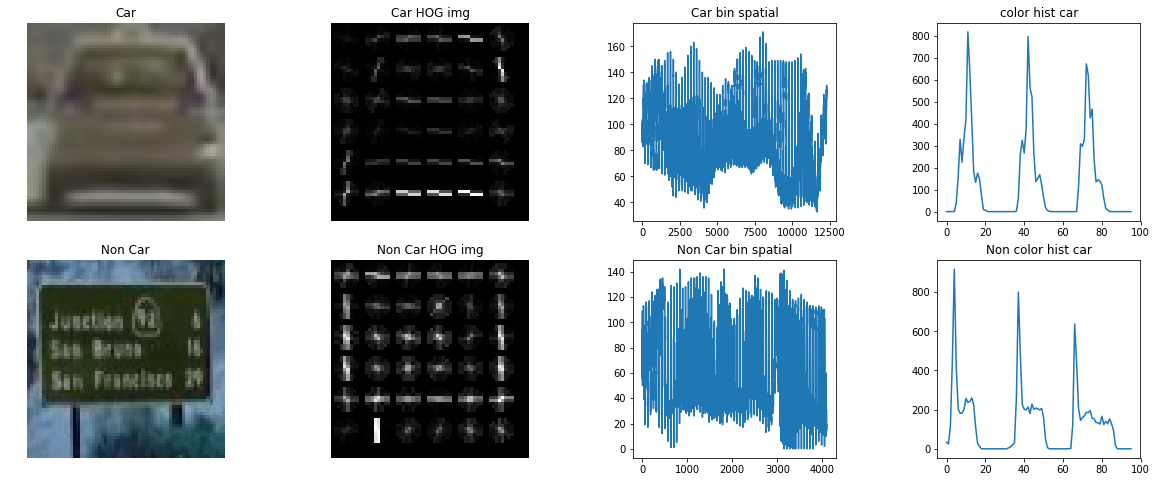

In [3]:
#Reading Vhiecle image
car_img = 'vehicles\GTI_Far\image0003.png'
car_img = cv2.imread(car_img)
car_img_YCrCb = cv2.cvtColor(car_img,cv2.COLOR_BGR2YCrCb)

#Reading Non-vehicle image
Non_car_img = 'non-vehicles\GTI\image3906.png'
Non_car_img = cv2.imread(Non_car_img)
Non_car_img_YCrCb = cv2.cvtColor(Non_car_img,cv2.COLOR_BGR2YCrCb)

#HOG parameters
orient = 10
pix_percell = 10
cell_per_block = 2

#HOG of car and Non-car
car_HOG_feature, car_HOG_img = get_hog_features(car_img, orient, pix_percell, cell_per_block, vis=True, feature_vec=True)
non_car_HOG_feature, non_car_HOG_img = get_hog_features(Non_car_img, orient, pix_percell, cell_per_block, vis=True, feature_vec=True)

#Bing_Spatial of car and Non-car
#Car Channel-1, 2, 3
car_bin_spatial = bin_spatial(car_img, color_space='YUV', size=(64, 64))

#Non-car Channel-1, 2, 3
Noncar_bin_spatial = bin_spatial(Non_car_img[:,:,0], size=(64, 64))

#color space of car & non-car
#color space of car
color_hist_car = color_hist(car_img, nbins=32, bins_range=(0, 256))
#color space of non car
color_hist_noncar = color_hist(Non_car_img, nbins=32, bins_range=(0, 256))


#Plot the image with Bin spatial, Color Hist and HOG
fig, axs = plt.subplots(2,4, figsize = (20,8))
fig.subplots_adjust(hspace = 0.2, wspace = 0.5)
axs = axs.ravel()
#Plot car features
axs[0].axis('off')
axs[0].imshow(car_img, cmap='gray')
axs[0].set_title('Car')
axs[1].axis('off')
axs[1].imshow(car_HOG_img, cmap='gray')
axs[1].set_title('Car HOG img')
axs[2].plot(car_bin_spatial)
axs[2].set_title('Car bin spatial')
axs[3].plot(color_hist_car)
axs[3].set_title('color hist car')
#Plot Noncar features
axs[4].axis('off')
axs[4].imshow(Non_car_img, cmap='gray')
axs[4].set_title('Non Car')
axs[5].axis('off')
axs[5].imshow(non_car_HOG_img, cmap='gray')
axs[5].set_title('Non Car HOG img')
axs[6].plot(Noncar_bin_spatial)
axs[6].set_title('Non Car bin spatial')
axs[7].plot(color_hist_noncar)
axs[7].set_title('Non color hist car')

# Concantenate features

Define function for concantenating features

In [4]:
def extract_features(imgs, cspace='RGB', orient=8,
                    pix_per_cell=8, cell_per_block=2, hog_channel='All', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    #Create a list to append feature vectors to
    features = []
    #Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        try:
            image = cv2.imread(file)
        except TypeError:
            image = file
            print ("extract feature image shape", image.shape)
        if image.shape != (64, 64, 3):
            image = cv2.resize(image, (64, 64))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   
        
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        
        #call get_hog_features() with vis=False, feature_vec = Ture
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)) 
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                               pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #Append the new feature vector to features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

# Train the SVM classifier

Collect car and Non car images

In [5]:
images = glob.glob('*.png')
cars = []
notcars = []
car_images = glob.glob('vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
#Collect car images
for image in car_images:
    cars.append(image)
#Collect non-car images
for image in noncar_images:
    notcars.append(image)
    
#Reduce the sample size because HOG features are slow to compute
#The quiz evaluator times out after 13s of CPU time
sample_size = 9000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]
print (len(cars))
print (len(notcars))

8792
8976


Train SVM Classifier

In [6]:
from sklearn import svm
### Parameters for features extraction
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 10
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

spatial_feat_decision = True
hist_feat_decision = True
hog_feat_decision = True

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256),
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat_decision, hist_feat=hist_feat_decision, hog_feat=hog_feat_decision)

notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256),
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat_decision, hist_feat=hist_feat_decision, hog_feat=hog_feat_decision)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.4, random_state=rand_state)
    
#Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
#Apply the scaler to X 
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

#Use a linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print ("run time:", '{:f}'.format(t2-t))

Test Accuracy of SVC =  0.9934
My SVC predicts:  [1. 1. 0. 0. 0. 1. 0. 0. 1. 1.]
For these 10 labels:  [1. 1. 0. 0. 0. 1. 0. 0. 1. 1.]
run time: 0.013960


# Sliding window search

In [7]:
#single picture feature extraction
def single_extract_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))    
            hog_features = np.array(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

Define sliding window for all images

In [8]:
#Define a the sliding window search function
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_windows=[(96, 96), (128, 128), (160, 160)], xy_overlap=(0.85, 0.85)):
    #Initialize a list to append window positions to
    window_list = []
    #Loop through the windows size lists
    for xy_window in xy_windows:
        #If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        #Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        #Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        #Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*xy_overlap[0])
        ny_buffer = np.int(xy_window[1]*xy_overlap[1])
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
        #Loop through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[0]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

#Define draw box functions
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    #Make a copy of the image
    imcopy = np.copy(img)
    if bboxes == None:
        return imcopy
    elif len(bboxes) == 0:
        return imcopy
    else:
        for bbox in bboxes:
            #Draw a rectagle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        return imcopy

Sliding windows on test

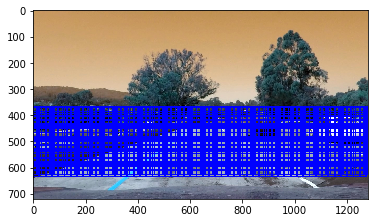

In [9]:
#Implement sliding windows on test image:
car_img = r'.\test_images\test1.jpg'
car_img = cv2.imread(car_img)
y_start_stop = [370, 640] # Min and max in y to search in slide_window()
windows = slide_window(car_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_windows=[(64, 64), (96, 96), (128, 128)], xy_overlap=(0.75, 0.75))
window_img = draw_boxes(car_img, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

Test on window searching and detecting vehicles

In [10]:
#Define searh windows
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=False, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Hog Sub-sampling Window Search

Define functions for car finding

In [11]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

HOG Sampling and create heat map

Defined Advanced Search

# Advanced Search

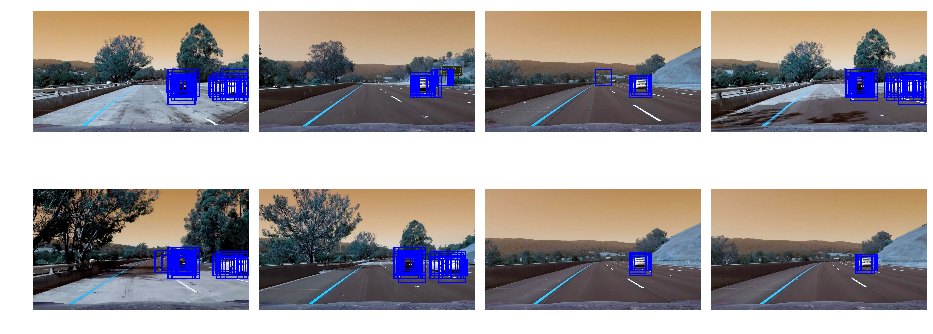

In [19]:
#Apply advanced search
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 10
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

#Test functions on sample image
test_images = glob.glob(r'./test_images/*.jpg')

#Create subplots
fig, axs = plt.subplots(2,4, figsize = (16,6))
fig.subplots_adjust(hspace = 0.2, wspace = 0.05)
axs = axs.ravel()
x_start_stop1 = [800, None]
x_start_stop2 = [400, 1200]
y_start_stop1 = [350, 650]
y_start_stop2 = [350, 500]
for i, img in enumerate(test_images):
    img = cv2.imread(img)
    draw_image = np.copy(img)
    windows1 = slide_window(img, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_windows=[(96, 96), (128, 128), (160, 160)], xy_overlap=(0.85, 0.85))
    windows2 = slide_window(img, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_windows=[(96, 96), (128, 128), (160, 160)], xy_overlap=(0.85, 0.85))
    windows = windows1 + windows2
    hot_windows = []
    hot_windows += search_windows(img, windows, svc, X_scaler, color_space=colorspace,
                  spatial_size=spatial_size, hist_bins=hist_bins,
                  hist_range=(0,256), orient=orient, 
                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                  hog_channel=hog_channel, spatial_feat=spatial_feat_decision,
                  hist_feat=hist_feat_decision, hog_feat=hog_feat_decision)  
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    axs[i].axis('off')
    axs[i].imshow(window_img, cmap='gray')

# Remove False Positive by using heatmap

In [20]:
#Heat map
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

#Apply threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#Draw label boxes
def draw_labeled_bboxes(img, labels):
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bbox_list.append(bbox)
    return img, bbox_list

# Testing on test images

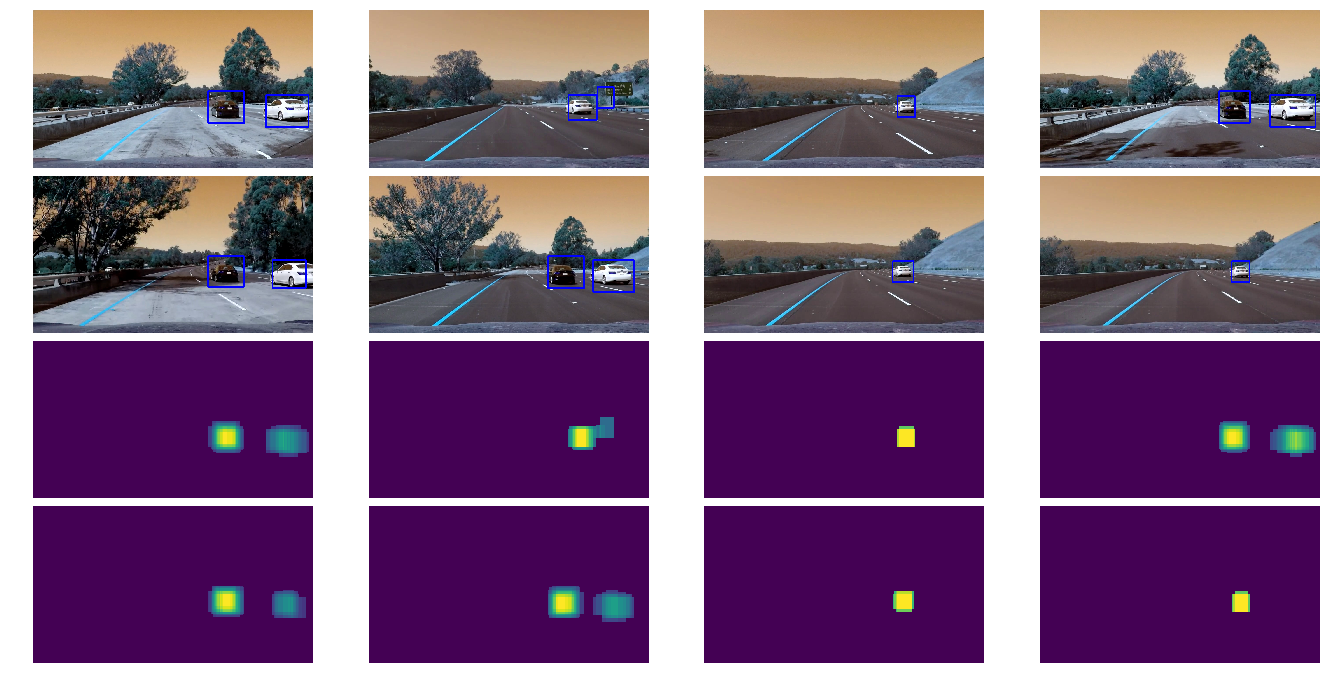

In [21]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 10
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

#Create subplots
fig, axs = plt.subplots(4,4, figsize = (24,12))
fig.subplots_adjust(hspace = 0.05, wspace = 0.01)
axs = axs.ravel()

heat_list = []

y_start_stop = [400, 640]

for i, img in enumerate(test_images):
    img = cv2.imread(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_image = np.copy(img)
    
    #Create detection windows
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=colorspace,
                  spatial_size=spatial_size, hist_bins=hist_bins,
                  hist_range=(0,256), orient=orient, 
                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                  hog_channel=hog_channel, spatial_feat=spatial_feat_decision,
                  hist_feat=hist_feat_decision, hog_feat=hog_feat_decision)  
    
    heat = add_heat(heat, hot_windows)
    heat_list.append(heat)
    
    heat_threshold = apply_threshold(heat, 5)
    
    labels = label(heat_threshold)
    
    draw_image, boxes = draw_labeled_bboxes(np.copy(img), labels)
    
    axs[i].axis('off')
    axs[i].imshow(draw_image, cmap='gray')
    
for i in range(8):
    axs[i+8].axis('off')
    axs[i+8].imshow(heat_list[i])

# Make vedio

In [15]:
# Smooth the car boxes
def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

# Distance beetween two points
def len_points(p1, p2): 
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

# Create box coordinates out of its center and span
def track_to_box(p): 
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))

In [26]:
def frame_proc(img, THRES, ALPHA, video = False):
    heat_list = []
    global n_count
    if (video and n_count%2==0) or not video: # Skip every second video frame
        global heat_p, boxes_p
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        x_start_stop1 = [800, None]
        x_start_stop2 = [400, 1200]
        y_start_stop1 = [350, 650]
        y_start_stop2 = [350, 500]
        
        boxes = slide_window(img, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_windows=[(96, 96), (128, 128), (160, 160)], xy_overlap=(0.85, 0.85))
        boxes += slide_window(img, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_windows=[(96, 96), (128, 128), (160, 160)], xy_overlap=(0.85, 0.85))
        

        hot_windows = search_windows(img, boxes, svc, X_scaler, color_space=colorspace,
              spatial_size=spatial_size, hist_bins=hist_bins,
              hist_range=(0,256), orient=orient, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
              hog_channel=hog_channel, spatial_feat=True,
              hist_feat=True, hog_feat=True)
        heat = add_heat(heat, hot_windows)
        if n_count == 0:
            heat_p = heat
        else:
            heat_p = heat
            heat = heat*ALPHA + heat_p*(1-ALPHA)
        
        #Average the heat map on pervious frames
        if len(heat_list) == 0:
            heat_l = heat
            heat_l = apply_threshold(heat_l, THRES)
            heat_list.append(heat_l)
        elif len(heat_list) <= 3:
            heat_l = np.average(heat_list)
            heat_l = apply_threshold(heat_l, THRES)
            heat_list.append(heat_l)
        else:
            heat_list.pop(0)
            heat_l=np.average(heat_list)
            heat_l = apply_threshold(heat_l, THRES)
            heat_list.append(heat_l)
            
        labels = label(heat_l)
        # Find final boxes from heatmap using label function
        imp, cars_boxes = draw_labeled_bboxes(np.copy(img), labels)
        boxes_p = cars_boxes
        
    else:
        cars_boxes = boxes_p
        imp = draw_boxes(np.copy(img), cars_boxes, color=(0, 0, 255), thick=6)
    n_count += 1
    return imp


In [25]:
from moviepy.editor import VideoFileClip
#
n_count = 0
THRES = 5 # Minimal overlapping boxes
ALPHA = 0.7 # Filter parameter, weight of the previous measurements

track_list = []#[np.array([880, 440, 76, 76])]
THRES_LEN = 32
#Y_MIN = 440

heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, THRES, ALPHA, video=True), cv2.COLOR_BGR2RGB)

output_v = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

Moviepy - Building video project_video_proc.mp4.
Moviepy - Writing video project_video_proc.mp4



Moviepy - Done !
Moviepy - video ready project_video_proc.mp4
Wall time: 47min 49s
